Supervised Learning

Task and Data

    The task we will perform is to quantitatively analyze forest cover change over time in the area surrounding the village Ces in Ticino, Switzerland
    We are provided with historic areal imagery from 1961 from swisstopo [source]
    The resolution of the imagery is 1 m/pixel and it contains only one single band (!!!)


In [17]:
import rasterio
import rasterio.plot 
from rasterio.transform import from_origin 
from rasterio.plot import plotting_extent
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.colors import Normalize
from matplotlib.colors import ListedColormap
import geopandas as gpd
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score

In [2]:
# add path to your data
%cd /Users/scli/Documents/ZHAW/Teaching/Remote Sensing 24/Data

/Users/scli/Documents/ZHAW/Teaching/Remote Sensing 24/Data


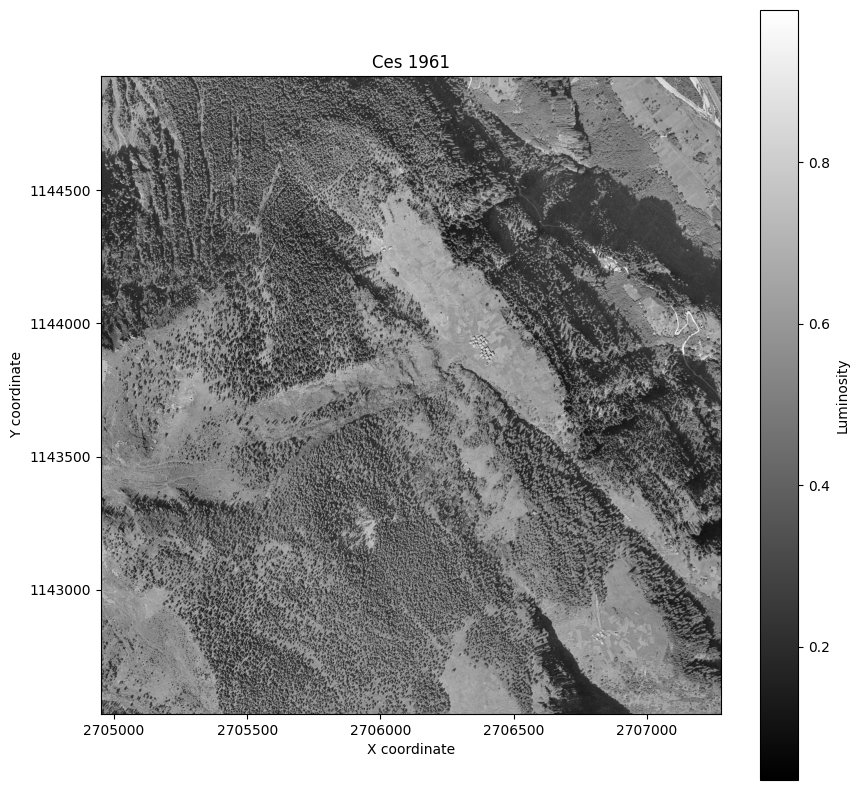

In [3]:
# Define the path to the .tif file using the current working directory
current_directory = os.getcwd()
tif_file_path = os.path.join(current_directory, "swisstopo/1961.tif")

# Open the .tif file
with rasterio.open(tif_file_path) as dataset:
    # Read the raster data as a numpy array
    ces1961 = dataset.read(1)  # reading the first band
    transform = dataset.transform

# Normalize the values to [0,1]
ces1961_normalized = ces1961 / 255.0

# Determine the extent in spatial coordinates
extent = rasterio.plot.plotting_extent(dataset)

# Define the formatter function to convert scientific notation to plain numbers
def to_plain_number(x, pos):
    return f'{x:.0f}'

# Plotting using matplotlib
plt.figure(figsize=(10, 10))
plt.imshow(ces1961_normalized, cmap='gray', extent=extent)
plt.colorbar(label='Luminosity')
plt.title('Ces 1961')
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
# Customize tick formatting to avoid scientific notation
plt.gca().xaxis.set_major_formatter(FuncFormatter(to_plain_number))
plt.gca().yaxis.set_major_formatter(FuncFormatter(to_plain_number))
plt.show()


Data labelling

In preparation, I used QGIS to create labelled points for the following classes:

    Forest
    Buildings
    Agriculture
    Shadows


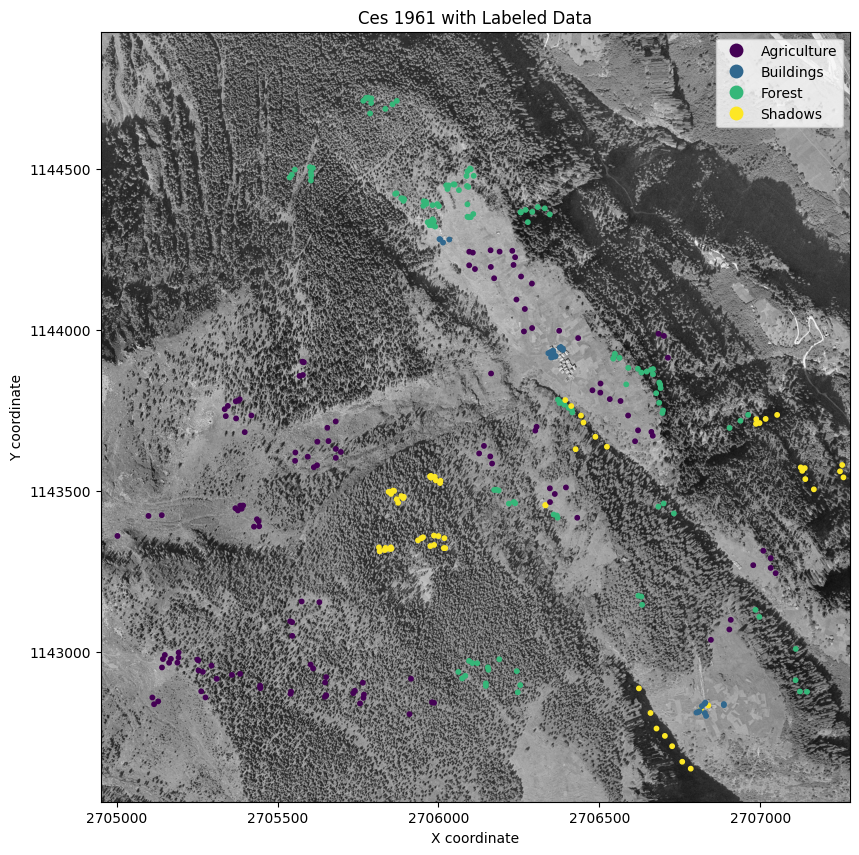

In [4]:
## Data Labelling

# Define the paths using the current working directory
gpkg_file_path = os.path.join(current_directory, "swisstopo/labelled-data.gpkg")

# Read the vector data
labelled_data = gpd.read_file(gpkg_file_path)

# Convert the 'class' column to categorical
labelled_data['class'] = labelled_data['class'].astype('category')

# Plot
fig, ax = plt.subplots(figsize=(10, 10))
# Plot raster data
plt.imshow(ces1961_normalized, cmap='gray', extent=rasterio.plot.plotting_extent(dataset), norm=Normalize())
# Plot vector data
labelled_data.plot(ax=ax, column='class', legend=True, cmap='viridis', markersize=10)
# Adjust layout
ax.set_title('Ces 1961 with Labeled Data')
ax.set_xlabel('X coordinate')
ax.set_ylabel('Y coordinate')
# Customize tick formatting to avoid scientific notation
plt.gca().xaxis.set_major_formatter(FuncFormatter(to_plain_number))
plt.gca().yaxis.set_major_formatter(FuncFormatter(to_plain_number))
plt.show()

Splitting the data

    We need to split our data into training and testing data
    We will randomly select 70% of the data for training and the remaining 30% for testing


In [5]:
## Splitting the data

# Assuming 'labelled_data' is your input DataFrame
np.random.seed(42)  # Set the seed for reproducibility

# Shuffle the entire DataFrame
labelled_data_shuffled = labelled_data.sample(frac=1, random_state=42).reset_index(drop=True)

# Split by ensuring 70-30 split for each class
data_train_list = []
data_test_list = []

# Group data by class to maintain proportions
for class_label, group in labelled_data_shuffled.groupby('class'):
    # Determine split size
    train_size = int(len(group) * 0.7)
    
    # Split the group
    data_train_chunk = group.iloc[:train_size]
    data_test_chunk = group.iloc[train_size:]
    
    # Collect the splits
    data_train_list.append(data_train_chunk)
    data_test_list.append(data_test_chunk)

# Concatenate the collected DataFrames
data_train = pd.concat(data_train_list).reset_index(drop=True)
data_test = pd.concat(data_test_list).reset_index(drop=True)

# Assuming data_train and data_test are your split datasets
# Shuffle the resulting datasets to ensure random distribution of samples
data_train = data_train.sample(frac=1, random_state=42).reset_index(drop=True)
data_test = data_test.sample(frac=1, random_state=42).reset_index(drop=True)

# Optional: Print the first few rows to verify
print(data_train.head())
print(data_test.head())

         class                         geometry
0       Forest   POINT (2705962.315 1144392.76)
1  Agriculture  POINT (2706346.759 1143465.656)
2    Buildings  POINT (2706014.148 1144272.433)
3  Agriculture  POINT (2706503.699 1143834.248)
4    Buildings  POINT (2706361.604 1143918.234)
         class                         geometry
0       Forest  POINT (2705834.842 1144688.129)
1  Agriculture  POINT (2705445.799 1142891.503)
2  Agriculture  POINT (2706611.137 1143654.776)
3       Forest  POINT (2706094.926 1142971.742)
4       Forest  POINT (2706686.436 1143837.237)


/var/folders/jv/jvcxtxx14p73bgbryl0jn21r0000gr/T/ipykernel_75224/1401330605.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for class_label, group in labelled_data_shuffled.groupby('class'):


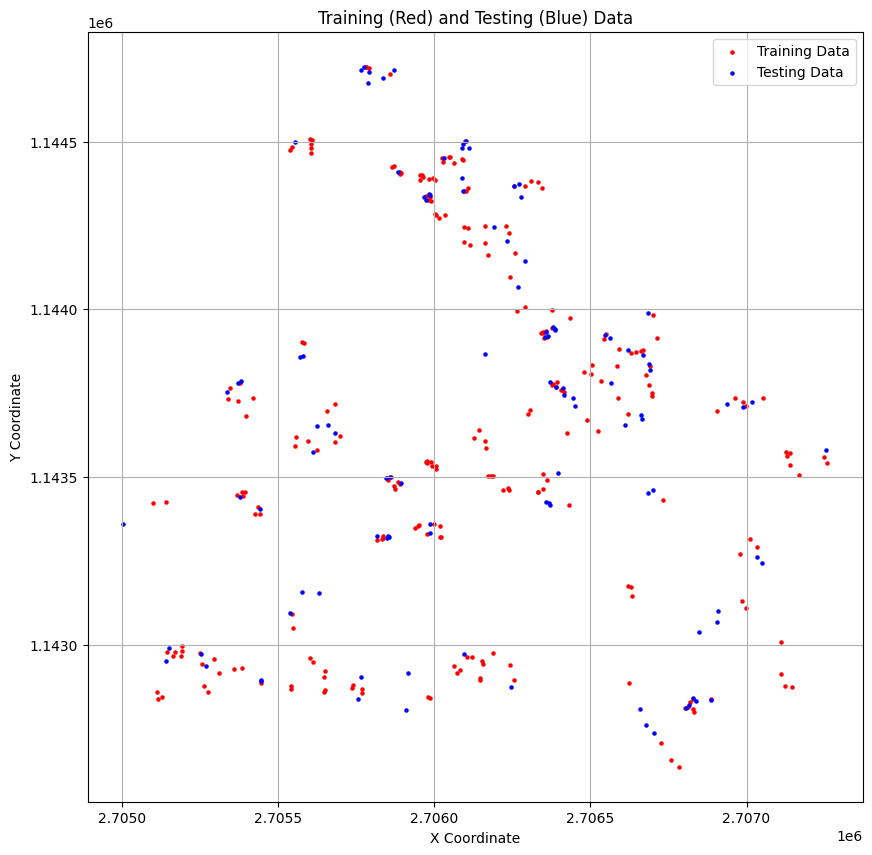

In [6]:
# Function to extract x, y coordinates from the Point objects
def extract_coordinates(geometry_series):
    x_coords = [point.x for point in geometry_series]
    y_coords = [point.y for point in geometry_series]
    return x_coords, y_coords

# Extract coordinates from geometry
train_x, train_y = extract_coordinates(data_train['geometry'])
test_x, test_y = extract_coordinates(data_test['geometry'])

# Create the plot
plt.figure(figsize=(10, 10))

# Plot training data (in red)
plt.scatter(train_x, train_y, c='red', label='Training Data', s=5)

# Plot testing data (in blue)
plt.scatter(test_x, test_y, c='blue', label='Testing Data', s=5)

# Customize plot
plt.title('Training (Red) and Testing (Blue) Data')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.legend()
plt.grid(True)

plt.show()

Focal filters

    Focal Filters, as we have seen in the chapter Focal, aggregate the values over a (moving) neighborhood of pixels.
    We can determine the size and shape of this neighborhood by specifying a matrix


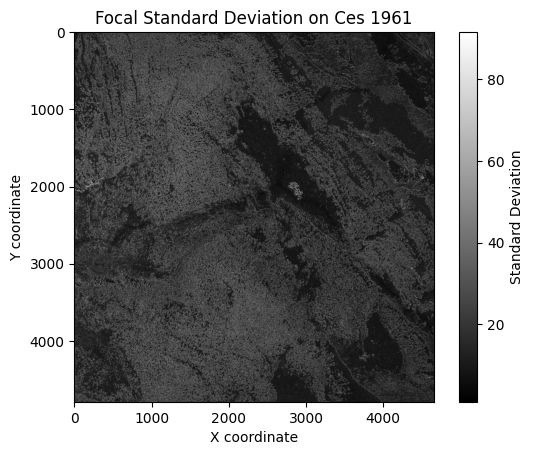

In [8]:
from scipy.ndimage import generic_filter

# Custom function to handle NaN properly
def focal_sd(values):
    finite_values = values[np.isfinite(values)]
    if finite_values.size == 0:
        return np.nan
    return np.std(finite_values)

# Apply a 5x5 focal operation using the standard deviation
n = 5
r_foc3 = generic_filter(ces1961, focal_sd, size=n, mode='constant', cval=np.nan)

# Plot the resulting array
plt.imshow(r_foc3, cmap='gray')
plt.colorbar(label='Standard Deviation')
plt.title('Focal Standard Deviation on Ces 1961')
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.show()

Using focal filters as features

    To use the focal filters as features, the values of the focal filters need to be normalized to [0,1]
    A simple way to do this is to use the min-max normalization:


In [9]:
# Function to perform min-max normalization
def minmax_normalization(arr):
    minval = np.amin(arr)
    maxval = np.amax(arr)
    return (arr - minval) / (maxval - minval)

# Apply min-max normalization
r_foc3_normalized = minmax_normalization(r_foc3)

# Stack the bands to form a multi-band raster
ces_stack = np.stack((ces1961_normalized, r_foc3_normalized), axis=-1)

ces_stack.shape

(4788, 4656, 2)

Feature Extraction

    We need to extract the values of the raster data at the labelled points
    Since we only have one band, our result is a data.frame with one column


In [10]:
## Feature Extraction

# Function to convert geographic coordinates to raster indices
def coordinate_to_index(point, transform):
    col, row = ~transform * (point.x, point.y)
    return int(row), int(col)

# Function to extract values using the transformed indices
def extract_raster_values(stack, points_gdf, transform):
    extracted_values = []
    for point in points_gdf.geometry:
        y, x = coordinate_to_index(point, transform)  # Convert to raster indices
        if 0 <= y < stack.shape[0] and 0 <= x < stack.shape[1]:
            values = stack[y, x, :]  # Extract values from all bands
            extracted_values.append(values)
        else:
            extracted_values.append([np.nan] * stack.shape[2])  # Out-of-bounds handling
    return np.array(extracted_values)

# Assuming ces_stack is your stacked raster data
train_features_b = extract_raster_values(ces_stack, data_train, transform)

# Print the extracted features
print(train_features_b)

# Assuming each band represents one feature like in R's 'terra::extract'
band_labels = ["luminosity", "focal3by3"]

# Construct DataFrame of extracted features along with the class column
train_features_b_df = pd.DataFrame(train_features_b, columns=band_labels)

# Combine with class data from the original GeoDataFrame
data_train_no_geom = data_train.drop(columns='geometry')
data_train2_b = pd.concat([data_train_no_geom, train_features_b_df], axis=1)

# Output the result
print(data_train2_b.head())

[[0.10196079 0.26214316]
 [0.6509804  0.07786678]
 [0.9647059  0.08606696]
 [0.63529414 0.05931668]
 [0.85490197 0.07124717]
 [0.32156864 0.28289023]
 [0.42352942 0.41459754]
 [0.5921569  0.17525773]
 [0.62352943 0.06355354]
 [0.84705883 0.07191712]
 [0.6901961  0.16585611]
 [0.19607843 0.07138631]
 [0.21960784 0.06144182]
 [0.20784314 0.12172291]
 [0.6784314  0.13645704]
 [0.3137255  0.06615763]
 [0.39607844 0.18736853]
 [0.65882355 0.07743527]
 [0.19607843 0.26552513]
 [0.6431373  0.06810501]
 [0.16078432 0.08212049]
 [0.75686276 0.08666154]
 [0.5294118  0.20082372]
 [0.61960787 0.060615  ]
 [0.57254905 0.10142409]
 [0.6745098  0.12465487]
 [0.5647059  0.1163436 ]
 [0.39607844 0.18375674]
 [0.6784314  0.06730606]
 [0.6745098  0.21106921]
 [0.35686275 0.26777354]
 [0.6        0.08929179]
 [0.33333334 0.4465743 ]
 [0.23137255 0.13758075]
 [0.61960787 0.0871853 ]
 [0.654902   0.0693176 ]
 [0.62352943 0.08283527]
 [0.32156864 0.3383572 ]
 [0.58431375 0.124191  ]
 [0.6509804  0.13314825]


Training the model

    We will use the rpart package to train a classification tree
    The classification tree is also known as a decision tree
    A decision tree has a flowchart-like structure (see Figure 6.1)
    Classification trees does not always produce the best results, but they are simple and interpretable


In [12]:
### Training the model

# Assuming data_train2_b is prepared like your R dataset
X_train = data_train2_b.drop(columns=['class'])
y_train = data_train2_b['class']

# Train the Decision Tree model
cart_modelb = DecisionTreeClassifier(max_depth=10)  # Optionally specify a max_depth for simplicity
cart_modelb.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10)

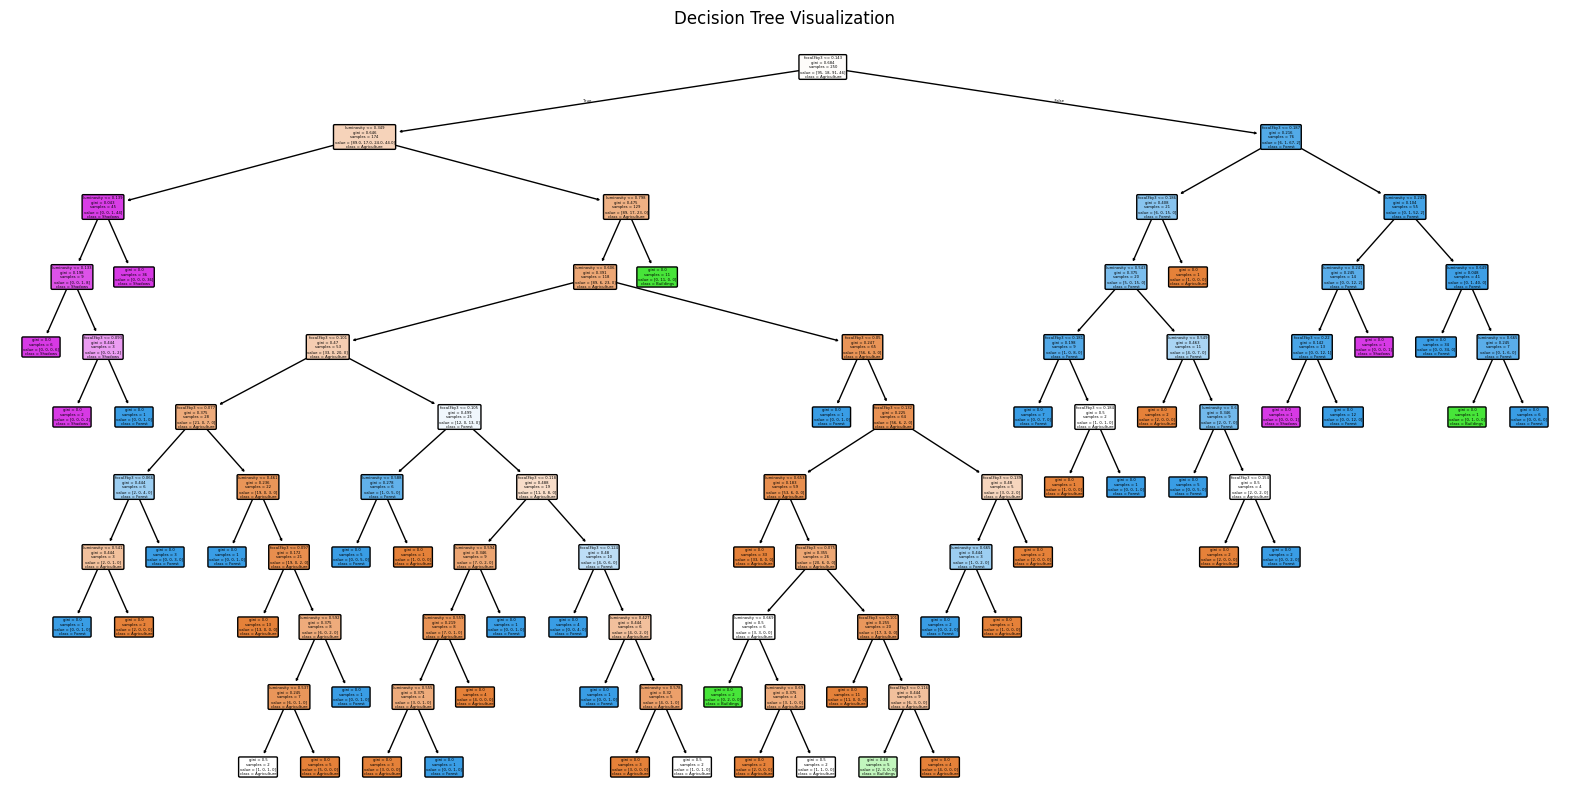

In [13]:
# Visualize the decision tree
plt.figure(figsize=(20, 10))
plot_tree(cart_modelb, filled=True, feature_names=X_train.columns, class_names=cart_modelb.classes_, rounded=True)
plt.title("Decision Tree Visualization")
plt.show()

Highest probability class

    We can combine the four layers into a single layer by assigning the class with the highest probability to each pixel
    For this, we can use the which.max function:


In [14]:
# Typically, (n_samples, n_features) shape is required, so keep that in mind
ces_shape_flat = ces_stack.reshape(-1, ces_stack.shape[2])  # Flatten to (n_samples, n_features)

# Train the Decision Tree model - assuming this was done as above
# cart_modelb = DecisionTreeClassifier(random_state=42)
# cart_modelb.fit(X_train, y_train)

# Predict the probability of each class for each sample in the flattened grid
ces_predict_prob = cart_modelb.predict_proba(ces_shape_flat)

# Determine the class with highest probability for each pixel in the grid
ces_predict2b_indices = np.argmax(ces_predict_prob, axis=1)
ces_predict2b_classes = [cart_modelb.classes_[i] for i in ces_predict2b_indices]

# Optionally reshape this prediction back to original raster dimensions for visualization
ces_predict2b_grid = np.array(ces_predict2b_classes).reshape(ces_stack.shape[0], ces_stack.shape[1])

# Output a preview of probabilities and predicted classes for verification
print("Sample probabilities and predicted classes:")
print(ces_predict_prob[0])  # Print the probabilities of the first sample
print(ces_predict2b_classes[:5])  # Print the first few predicted classes


/Users/scli/anaconda3/envs/tf/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


Sample probabilities and predicted classes:
[1. 0. 0. 0.]
['Agriculture', 'Forest', 'Agriculture', 'Agriculture', 'Buildings']


Model Evaluation

    To evaluate the model, we will use the testing data


In [26]:
def extract_predicted_classes(predicted_grid, points_gdf, transform):
    predictions_at_points = []
    for point in points_gdf.geometry:
        y, x = coordinate_to_index(point, transform)  # Get the indices
        if 0 <= y < predicted_grid.shape[0] and 0 <= x < predicted_grid.shape[1]:
            pred_class = predicted_grid[y, x]  # Use correct indices
            predictions_at_points.append(pred_class)
        else:
            predictions_at_points.append(None)  # Handle out-of-bounds indices
    return predictions_at_points

# Ensure you're passing the correct GeoDataFrame and using the function name correctly
test_featuresb = extract_predicted_classes(ces_predict2b_grid, data_test, transform)

# Check results
print(test_featuresb[:5])

['Forest', 'Agriculture', 'Agriculture', 'Forest', 'Forest']


In [28]:
from sklearn.metrics import confusion_matrix
# Example confusion matrix construction (construct your real predicted vs actual as needed)
data_test['predicted'] = test_featuresb

confusion_matb = confusion_matrix(data_test['class'], data_test['predicted'], labels=cart_modelb.classes_)

# Convert to DataFrame for better reading
confusion_matrix_df = pd.DataFrame(confusion_matb, index=cart_modelb.classes_, columns=cart_modelb.classes_)

# Display the confusion matrix
print(confusion_matrix_df)

# Calculate accuracy
correct_predictions = np.trace(confusion_matb)  # Sum of diagonal elements
total_predictions = np.sum(confusion_matb)      # Sum of all elements
accuracy = correct_predictions / total_predictions

# Display the calculated accuracy
print(f"Accuracy: {accuracy:.2f}")

             Agriculture  Buildings  Forest  Shadows
Agriculture           30          0      11        0
Buildings              5          2       2        0
Forest                 9          0      30        0
Shadows                0          0       4       16
Accuracy: 0.72
